In [1]:
# load necessary libraries
import numpy as np
from scipy import ndimage
from scipy import misc
from scipy import stats
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import filters
from skimage.feature import canny
# for finding continuous sequences in a list
from operator import itemgetter
from itertools import groupby

# change plot size
mpl.rcParams['figure.figsize'] = (15, 15)

## Image modifying functions

In [2]:
# read in an image
def readImg(filename, plotIt = False):
    # read in image file
    let = misc.imread(filename)
    # read it in as grey
    grey = misc.imread(filename, flatten=True)
    
    if plotIt:        
        plt.imshow(let)
        plt.show()
        plt.imshow(grey, cmap = "gray")
        plt.show()
    return let, grey

# project the image onto a specific direction
def project(img, direction):
    if direction == "x":
        proj = np.sum(img, 0)
    elif direction == "y":
        proj = np.sum(img, 1)
    else:
        print("Direction must be one of 'x' or 'y'")
        proj = []
    return proj

def removeEdges(imgCol, imgGr, rmThresh = 0):
    imgGrCp = imgGr.copy()
    imgColCp = imgCol.copy()
    
    imgY = project(imgGrCp, "y")
    imgGrCp = imgGrCp[imgY > rmThresh]
    imgColCp = imgColCp[imgY > rmThresh]
    
    imgX = project(imgGrCp, "x")
    imgGrCp = imgGrCp[:,imgX > rmThresh]
    imgColCp = imgColCp[:,imgX > rmThresh]
    return imgColCp, imgGrCp

# binarize an image
def binarizeImg(img, biThresh, plotIt = False):
    imgCp = img.copy()
    if biThresh == "otsu":
        biThresh = filters.threshold_otsu(imgCp)
    inds = imgCp > biThresh*255 
    imgCp[inds] = 1
    imgCp[np.logical_not(inds)] = 0
    if plotIt:
        plt.imshow(imgCp, cmap = "gray")
        plt.show()
    return imgCp

# smooth an image
def smoothImg(img, smoothSigma, plotIt = False):
    imgCp = ndimage.filters.gaussian_filter(input=img, sigma=smoothSigma)
    if plotIt:
        plt.imshow(imgCp, cmap = "gray")
        plt.show()
    return imgCp

# read in and do all pre-processing
def readAndPrep(filename, rmThresh = 0, biThresh = "otsu",
                smoothSigma = 10.0, plotIt = False):
    let, grey = readImg(filename, plotIt)
    let, grey = removeEdges(let, grey, rmThresh)
    greyBi = binarizeImg(grey, biThresh, plotIt)
    greySm = smoothImg(grey, smoothSigma, plotIt)
    return let, grey, greyBi, greySm

## Plotting functions

In [3]:
# plot "histogram"
def densityHist(proj, pers = []):
    plt.plot(proj)
    ny = proj.shape[0]
    for pe in pers:
        p = np.percentile(proj, pe)
        plt.plot([0,ny], [p, p])
        plt.text(x=ny, y=p, s=str(pe))
    plt.show()

# plot boxes around words (or just linebreaks)
def plotBoxes(img, linebreaks, wordbreaks = []):
    if len(linebreaks) == 0:
        linebreaks = [0, img.shape[0]]
    plt.imshow(img)
    for i in range(len(linebreaks)):
        plt.plot([0,img.shape[1]], [linebreaks[i], linebreaks[i]], 'b')
    for i in range(len(linebreaks)-1):
        plt.plot([wordbreaks[i], wordbreaks[i]], [linebreaks[i], linebreaks[i+1]], 'b')
    plt.show()

## Segmentation functions

In [4]:
# get breaks based on projection
def projBreaks(img, direction, thresh = 0):
    proj = project(img, direction)
    breaks = argrelextrema(proj, np.greater)[0]
    breaks = breaks[breaks > thresh]
    # append 0 and image size to ends of vector
    breaks = np.insert(breaks, 0, 0)
    breaks = np.append(breaks, proj.shape[0]) 
    return breaks

# get the breaks based on canny edge detection
def edgeBreaks(img, direction, thresh = 0):
    edges = canny(img, 5, 1, 25)
    eproj = project(edges, direction)
    br = np.sort(np.where(eproj <= thresh)[0])
    # get middle (mean) of continuous sequences
    br2 = []
    for k, g in groupby(enumerate(br), lambda (i,x):i-x):
        group = map(itemgetter(1), g)
        br2.append(np.mean(group))
    # append 0 and image size to ends of vector
    br2 = np.insert(br2, 0, 0)
    br2 = np.append(br2, eproj.shape[0]) 
    return br2
    
# split into words
def getWordBreaks(img, lineBreaks, method = "edge", thresh = 0):
    wordbreaks = []
    for i in range(len(lineBreaks)-1):
        chunk = img[lineBreaks[i]:lineBreaks[i+1],]
        if method == "edge":
            wordbreaks.append(edgeBreaks(chunk, "x", thresh))
        elif method == "proj":
            wordbreaks.append(projBreaks(chunk, "x", thresh))
    return wordbreaks

# segment the whole document
def segmentDoc(origImg, grImg1, grImg2, m1 = "proj", m2 = "edge",
               th1 = 0, th2 = 0, plotIt = True):
    # get line breaks
    if m1 == "proj":
        lineBreaks = projBreaks(grImg1, "y", th1)
    elif m1 == "edge":
        lineBreaks = edgeBreaks(grImg1, "x", th1)
    # get word breaks
    wordBreaks = getWordBreaks(grImg2, lineBreaks, m2, th2)
    # plot the image
    if plotIt:
        plotBoxes(origImg, lineBreaks, wordBreaks)
    return lineBreaks, wordBreaks

## Run segmentation on a couple of images

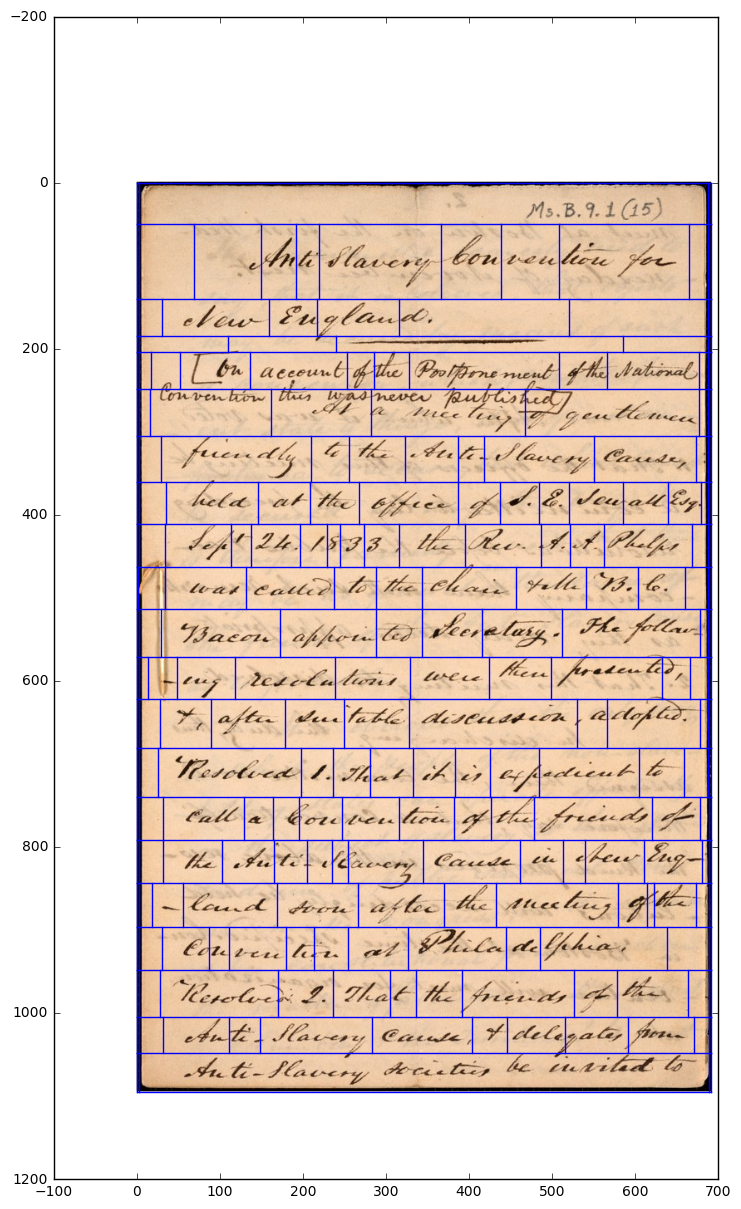

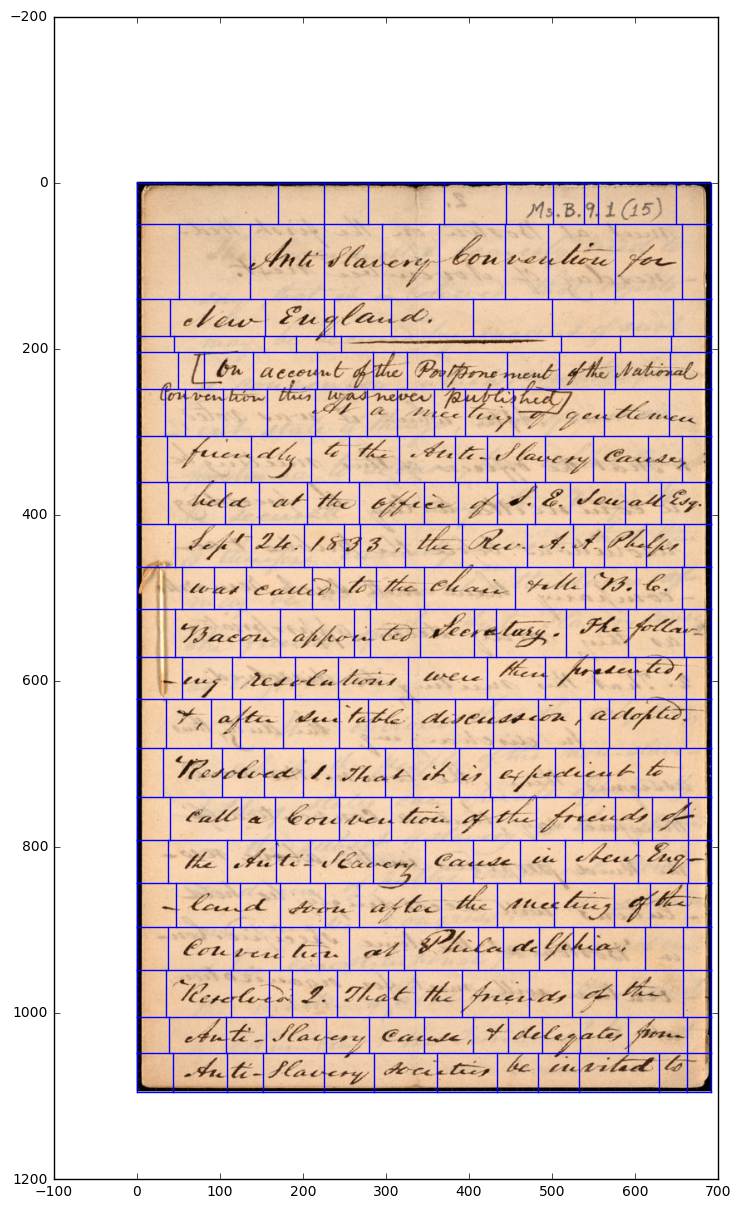

In [5]:
let, grey, greyBi, greySm = readAndPrep("images/easy.jpg")
lb, wb = segmentDoc(let, greySm, grey)
lb2, wb2 = segmentDoc(let, greySm, greySm, m2 = "proj")

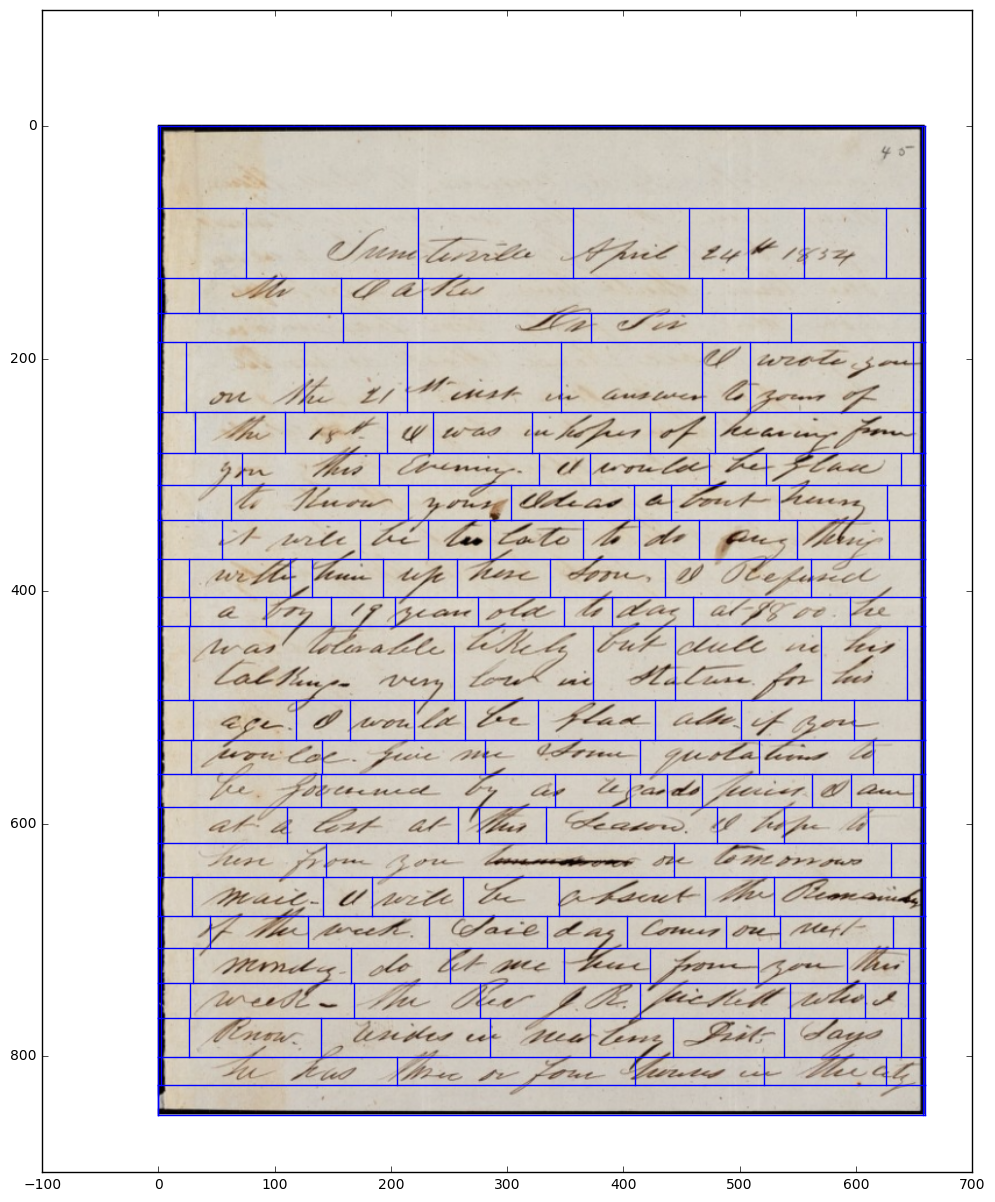

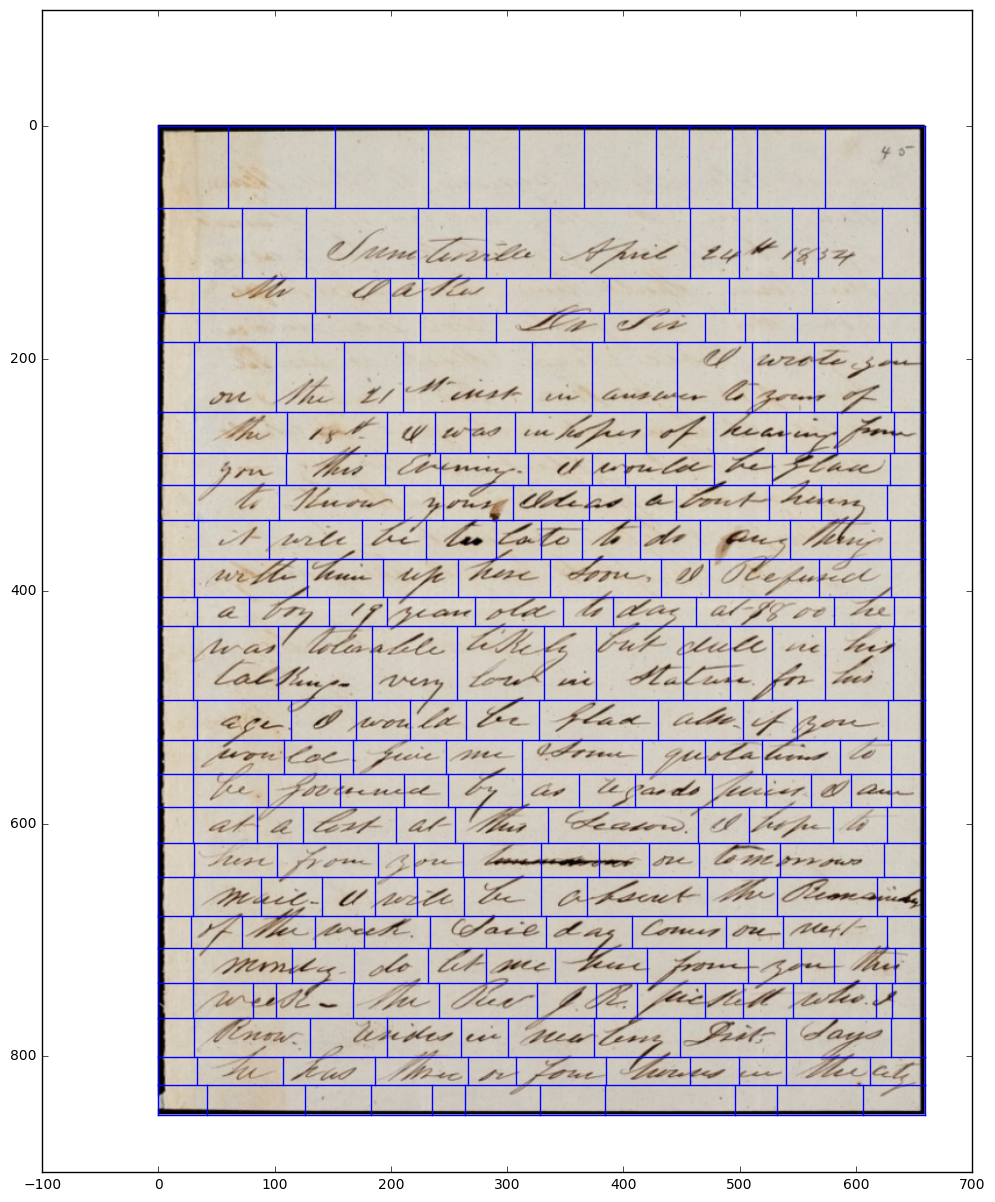

In [6]:
let, grey, greyBi, greySm = readAndPrep("images/medium.png")
lb, wb = segmentDoc(let, greySm, grey)
lb2, wb2 = segmentDoc(let, greySm, greySm, m2 = "proj")

# Old code

In [ ]:
# old get cutoffs
def getCutoffs(thresh, proj)
    linebreaks = []
    linebreaks2 = []
    above = False
    curmin = np.inf
    mindex = 0
    ny = proj.shape[0]
    for i in range(ny):
        curabove = proj[i] > thresh
        # method one - get the max of the region above
        if not above:
            if curabove:
                curmax = proj[i]
                maxdex = i
        else:
            if curabove:
                if grey_y[i] > curmax:
                    curmax = proj[i]
                    maxdex = i
            else:
                linebreaks.append(maxdex)
                curmax = np.inf

        # method 2 - get the center of the gap
        if not above and curabove:
            startloc = i
        if above and not curabove:
            linebreaks2.append(np.floor(np.mean([startloc, i])))

        above = curabove
    return linebreaks


In [ ]:
# read in an preprocess image
filename = "images/easy.jpg"; plotIt = True; smoothSigma = 2
# def readPrep(filename, plotIt, binaryThresh, smoothSigma):
# read in image file
let = misc.imread(filename)

# read it in as grey
grey1 = misc.imread(filename, flatten = True)
grey_x = np.sum(grey1, 0)
inds = grey_x > 0
grey1 = grey1[:,inds]
grey_y = np.sum(grey1, 1)
inds = grey_y > 0
grey1 = grey1[inds]
grey = grey1.copy()

# binarize
# if binaryThresh is not None:
binaryThresh = filters.threshold_otsu(grey1)
grey2 = grey1.copy()
grey2 = grey2 > binaryThresh
# grey2[inds] = 1
# grey2[np.logical_not(inds)] = 0
grey = grey2.copy()
print(binaryThresh)

# smooth
# if smoothSigma is not None:
grey3 = ndimage.filters.gaussian_filter(input=grey, sigma=smoothSigma)
grey = grey3.copy()

if plotIt:        
    plt.imshow(let)
    plt.show()
    plt.imshow(grey1, cmap='gray')
    plt.show()
    plt.imshow(grey2, cmap='gray')
    plt.show()
    plt.imshow(grey3, cmap='gray')
    plt.show()
# return let, grey


import matplotlib.pyplot as plt
from skimage import data
try:
    from skimage import filters
except ImportError:
    from skimage import filter as filters
from skimage import exposure

grey1 = misc.imread(filename, flatten = True)
grey_x = np.sum(grey1, 0)
inds = grey_x > 0
grey1 = grey1[:,inds]
grey_y = np.sum(grey1, 1)
inds = grey_y > 0
grey1 = grey1[inds]
camera = grey1.copy()
val = filters.threshold_otsu(camera)

hist, bins_center = exposure.histogram(camera)

plt.figure(figsize=(9, 4))
plt.subplot(131)
plt.imshow(camera, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(132)
plt.imshow(camera > val, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(133)
plt.plot(bins_center, hist, lw=2)
plt.axvline(val, color='k', ls='--')

plt.tight_layout()
plt.show()